In [1]:
import numpy as np
import cv2,os,pickle
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
model = load_model('cnn_classifier-70.h5')

In [3]:
def square(img):
    """
    This function resize non square image to square one (height == width)
    :param img: input image as numpy array
    :return: numpy array
    """

    # image after making height equal to width
    squared_image = img

    # Get image height and width
    h = img.shape[0]
    w = img.shape[1]

    # In case height superior than width
    if h > w:
        diff = h-w
        if diff % 2 == 0:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = x1
        else:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = np.zeros(shape=(h, (diff//2)+1))

        squared_image = np.concatenate((x1, img, x2), axis=1)

    # In case height inferior than width
    if h < w:
        diff = w-h
        if diff % 2 == 0:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = x1
        else:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = np.zeros(shape=((diff//2)+1, w))

        squared_image = np.concatenate((x1, img, x2), axis=0)

    return squared_image

def plate_segmentation(img_file_path):

    img = cv2.imread(img_file_path)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    height = img.shape[0]
    width = img.shape[1]
    area = height * width

    scale1 = 0.001
    scale2 = 0.1
    area_condition1 = area * scale1
    area_condition2 = area * scale2
    # global thresholding
    ret1,th1 = cv2.threshold(imgray,127,255,cv2.THRESH_BINARY)

    # Otsu's thresholding
    ret2,th2 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(imgray,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # sort contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    cropped = []
    for cnt in contours:
        (x,y,w,h) = cv2.boundingRect(cnt)


        if (w * h > area_condition1 and w * h < area_condition2 and w/h > 0.3 and h/w > 0.3):
            cv2.drawContours(img, [cnt], 0, (0, 255, 0), 3)
            cv2.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0), 2)
            c = th2[y:y+h,x:x+w]
            c = np.array(c)
            c = cv2.bitwise_not(c)
            c = square(c)
            c = cv2.resize(c,(28,28), interpolation = cv2.INTER_AREA)
            cropped.append(c)
    cv2.imwrite('detection.png', img)
    return cropped

In [4]:
digits = plate_segmentation('mm-plate.jpg')

In [5]:
len(digits)

20

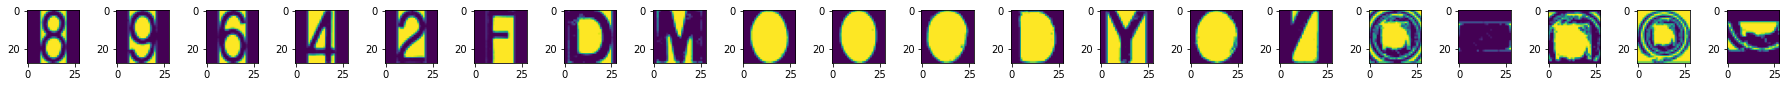

In [11]:
fig, axes = plt.subplots(nrows=1,ncols=20, figsize=(25, 7.5))
fig.tight_layout()
for i in range (20):
    axes[i].imshow(digits[i])

In [17]:
digit = np.reshape(digits[1], (1,28,28,1))

In [18]:
prediction = model.predict(digit)

In [19]:
type(prediction)

numpy.ndarray

In [20]:
alphabets = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
classes = []
for a in alphabets:
    classes.append([a])
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(classes)
pred = ohe.inverse_transform(prediction)

In [22]:
pred[0][0]

'C'

In [23]:
prediction

array([[2.20797509e-02, 3.02630360e-04, 6.33181480e-04, 1.16011724e-05,
        1.34495064e-03, 2.32395949e-03, 4.40149708e-03, 5.36854495e-05,
        2.09214818e-03, 2.78680498e-04, 7.15210917e-04, 1.75286038e-03,
        5.16220033e-01, 1.41406374e-03, 8.31993669e-02, 7.64596090e-03,
        1.24479644e-01, 2.46304116e-04, 6.01971708e-03, 7.30898522e-04,
        8.56716931e-03, 3.73677798e-02, 2.03274278e-04, 1.81701023e-03,
        3.45970802e-02, 1.89100881e-03, 7.57006258e-02, 2.13146253e-04,
        1.41649609e-02, 2.89411061e-02, 7.85139017e-03, 6.91099605e-03,
        1.37895823e-03, 3.74644937e-04, 1.83429732e-03, 2.24039191e-03]],
      dtype=float32)

In [9]:
for d in digits:

    d = np.reshape(d, (1,28,28,1))
    out = model.predict(d)
    # Get max pre arg
    p = []
    precision = 0
    for i in range(len(out)):
        z = np.zeros(36)
        z[np.argmax(out[i])] = 1.
        precision = max(out[i])
        p.append(z)
    prediction = np.array(p)

    # Inverse one hot encoding
    alphabets = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    classes = []
    for a in alphabets:
        classes.append([a])
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(classes)
    pred = ohe.inverse_transform(prediction)

    if precision > 0.6:
        print('Prediction : ' + str(pred[0][0]) + ' , Precision : ' + str(precision))

Prediction : D , Precision : 0.8543954
Prediction : 7 , Precision : 0.81099445
